<a href="https://colab.research.google.com/github/allen44/econometric-time-series-study/blob/main/econometric_time_series_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup

In [29]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')
import config
API_KEY = config.API_KEY

%cd /content/drive/MyDrive/Colab Notebooks/econ-data-time-series-study

/content/drive/MyDrive/Colab Notebooks/econ-data-time-series-study


In [30]:
import os

try:
  import requests_cache
except ModuleNotFoundError:
  os.system("pip install requests_cache")
  import requests_cache

try:
  import alphalens
except ModuleNotFoundError:
  os.system("pip install alphalens")
  import alphalens

try:
  import pmdarima
except ModuleNotFoundError:
  os.system("pip install pmdarima")
  import pmdarima
  

In [68]:
import datetime
import pandas_datareader.data as web
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

#pandas_datareader setup
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 1, 1)

# Historical Time Series Data from AlphaVantage

## Docs

https://pandas-datareader.readthedocs.io/en/latest/readers/alphavantage.html#module-pandas_datareader.av.time_series

>
>Through the [Alpha Vantage](https://www.alphavantage.co/documentation) Time >Series endpoints, it is possible to obtain historical equities and currency >rate data for individual symbols. For daily, weekly, and monthly frequencies, 20>+ years of historical data is available. The past 3-5 days of intraday data is >also available.
>
>The following endpoints are available:
>
>*   `av-intraday` - Intraday Time Series
>    
>*   `av-daily` - Daily Time Series
>    
>*   `av-daily-adjusted` - Daily Time Series (Adjusted)
>    
>*   `av-weekly` - Weekly Time Series
>    
>*   `av-weekly-adjusted` - Weekly Time Series (Adjusted)
>    
>*   `av-monthly` - Monthly Time Series
>    
>*   `av-monthly-adjusted` - Monthly Time Series (Adjusted)
>    
>*   `av-forex-daily` - Daily Time Series
>
>To request the historical exchange rate of physical or digital currencies, use >`av-forex-daily` and format the symbol as “FROM/TO”, for example “USD/JPY”.
>
>The top-level function `get_data_alphavantage` is also provided. This function >will return the `TIME_SERIES_DAILY` endpoint for the symbol and date range >provided.

In [32]:
# Get single stock prices
def get_stock_time_series(name="AAPL",
                          start=start, 
                          end=end,
                          column='adjusted close'):
  df = web.DataReader(name=name, 
                        data_source="av-daily-adjusted", 
                        start=start,
                        end=end,
                        session=session,
                        api_key=API_KEY['alphavantage'])
  df.index = pd.to_datetime(df.index)
  if column:
    df = df[column].rename(name)
  df.resample('B').asfreq()
  return df

get_stock_time_series()

2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

# Get FX pair prices from AlphaVantage

https://pandas-datareader.readthedocs.io/en/latest/readers/alphavantage.html#module-pandas_datareader.av.forex

In [33]:
# Get single FX prices
def get_fx_time_series(name="USDJPY", 
                       start=start, 
                       end=end,
                       column='close'):
  df = web.DataReader(name=name,
                    data_source="av-daily", 
                    start=start,
                    end=end,
                    session=session,
                    api_key=API_KEY['alphavantage'])
  df.index = pd.to_datetime(df.index)
  if column:
    df = df[column].rename(name)
  df.resample('B').asfreq()
  return df

get_fx_time_series()

2018-01-01    112.586
2018-01-02    112.227
2018-01-03    112.543
2018-01-04    112.775
2018-01-05    112.985
               ...   
2020-12-28    103.789
2020-12-29    103.560
2020-12-30    103.182
2020-12-31    103.259
2021-01-01    103.191
Name: USDJPY, Length: 785, dtype: float64

In [34]:
 real_gdp_us = web.DataReader('ticker=RGDPUS', 'econdb')
 real_gdp_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2016-07-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                               Non-Null Count  Dtype
---  ------                                                                                                                                                                                                                                               --------------  -----
 0   (T10106, A191RX, Table 1.1.6. Real Gross Domestic Product, Chained Dollars (A) (Q), Gross domestic product, Level, Q, Table 1.1.6. Real Gross Domestic Product, Chained Dollars [Billions of chained (2012) dollars] - LastRevised: April 29, 2021)  19 non-null     int64
dtypes: int64(1)
memory usage: 304.0 bytes


In [35]:
 fred_data_series_list = ['DAAA', 
                         'UNRATE', 
                         'PPIACO', 
                         'CPIAUCSL', 
                         'PERMIT', 
                         'UMCSENT', 
                         'CABPPRIVSA',
                         'VIXCLS']
 
fred_data = web.DataReader(name=fred_data_series_list,  
                           data_source='fred', 
                           start=start, 
                           end=end, 
                           session=session).resample('B').asfreq()
fred_data

,DAAA,UNRATE,PPIACO,CPIAUCSL,PERMIT,UMCSENT,CABPPRIVSA,VIXCLS
DATE,,,,,,,,
2018-01-01,NaN,4.0,197.9,248.721,1365.0,95.7,9602.284476,NaN
2018-01-02,3.52,NaN,NaN,NaN,NaN,NaN,NaN,9.77
2018-01-03,3.50,NaN,NaN,NaN,NaN,NaN,NaN,9.15
2018-01-04,3.47,NaN,NaN,NaN,NaN,NaN,NaN,9.22
2018-01-05,3.50,NaN,NaN,NaN,NaN,NaN,NaN,9.22
...,...,...,...,...,...,...,...,...
2020-12-28,2.25,NaN,NaN,NaN,NaN,NaN,NaN,21.70
2020-12-29,2.25,NaN,NaN,NaN,NaN,NaN,NaN,23.08
2020-12-30,2.22,NaN,NaN,NaN,NaN,NaN,NaN,22.77


## Dynamic forecasting with SARIMAX

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

name='AAPL'
time_series = get_stock_time_series(name=name)

def sarimax_forecast(endog=time_series,
                     exog=None,
                     order=(1,1,1),
                     seasonal_order=(0,0,0,0),
                     start=-30,
                     dynamic=True):
  from statsmodels.tsa.statespace.sarimax import SARIMAX
  model = SARIMAX(endog=time_series,
                  exog=exog,
                  order=order,
                  seasonal_order=seasonal_order)
  results=model.fit()

  # Generate predictions
  dynamic_forecast = results.get_prediction(start=start, dynamic=dynamic)

  # Extract prediction mean
  mean_forecast = dynamic_forecast.predicted_mean

  # Get confidence intervals of predictions
  confidence_intervals = dynamic_forecast.conf_int()

  # Select lower and upper confidence limits
  lower_limits = confidence_intervals.loc[:,f'lower {time_series.name}']
  upper_limits = confidence_intervals.loc[:,f'upper {time_series.name}']

  # # Print best estimate predictions
  # print(mean_forecast)
  return mean_forecast, lower_limits, upper_limits
sarimax_forecast()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


(2020-11-18    119.162050
 2020-11-19    119.109426
 2020-11-20    119.127666
 2020-11-23    119.121344
 2020-11-24    119.123535
 2020-11-25    119.122776
 2020-11-27    119.123039
 2020-11-30    119.122948
 2020-12-01    119.122979
 2020-12-02    119.122968
 2020-12-03    119.122972
 2020-12-04    119.122971
 2020-12-07    119.122971
 2020-12-08    119.122971
 2020-12-09    119.122971
 2020-12-10    119.122971
 2020-12-11    119.122971
 2020-12-14    119.122971
 2020-12-15    119.122971
 2020-12-16    119.122971
 2020-12-17    119.122971
 2020-12-18    119.122971
 2020-12-21    119.122971
 2020-12-22    119.122971
 2020-12-23    119.122971
 2020-12-24    119.122971
 2020-12-28    119.122971
 2020-12-29    119.122971
 2020-12-30    119.122971
 2020-12-31    119.122971
 dtype: float64, 2020-11-18    115.987439
 2020-11-19    114.914742
 2020-11-20    114.032784
 2020-11-23    113.288488
 2020-11-24    112.628207
 2020-11-25    112.029068
 2020-11-27    111.476833
 2020-11-30    110.961

Plotting dynamic forecasts

In [37]:
time_series
# time_series.index = pd.DatetimeIndex(time_series.index).to_period('B')

2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


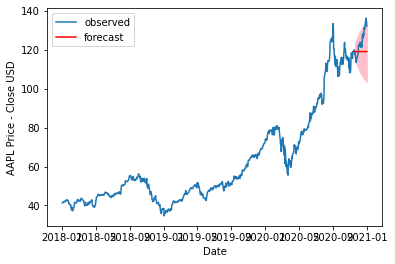

In [38]:
name='AAPL'
time_series = get_stock_time_series(name=name)

def plot_dynamic_forecast(endog=time_series,
                          exog=None,
                          order=(1,1,1),
                          seasonal_order=(0,0,0,0)):
  (mean_forecast, 
  lower_limits, 
  upper_limits) = sarimax_forecast(endog=time_series,
                                  exog=exog,
                                  order=order,
                                  seasonal_order=seasonal_order)
  # plot the observed data
  plt.plot(endog.index, endog, label='observed')

  # plot your mean forecast
  plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

  # shade the area between your confidence limits
  plt.fill_between(lower_limits.index, lower_limits, 
          upper_limits, color='pink')

  # set labels, legends and show plot
  plt.xlabel('Date')
  plt.ylabel(f'{name} Price - Close USD')
  plt.legend()
  plt.show()

plot_dynamic_forecast()

Box-Jenkins Method: identify, estimate, model, diagnostics

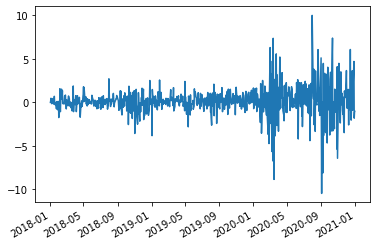

test statistic: -8.443930110470156
p-value: 1.7332051602480466e-13
Data is stationary.


True

In [39]:
def indentification(series_with_unknown_charecteristics):
  from statsmodels.tsa.stattools import adfuller
  # Check for stationarity
  # Plot time series
  series_with_unknown_charecteristics.plot()
  plt.show()

  # Run Dicky-Fuller test
  result = adfuller(series_with_unknown_charecteristics)

  # Print test statistic
  print(f'test statistic: {result[0]}')

  # Print p-value
  print(f'p-value: {result[1]}')

  if result[1] < 0.05: 
    print('Data is stationary.')
    stationary_series = series_with_unknown_charecteristics
    return True
  else:
    print('Data is not stationary')
    return False
indentification(time_series.diff().dropna())

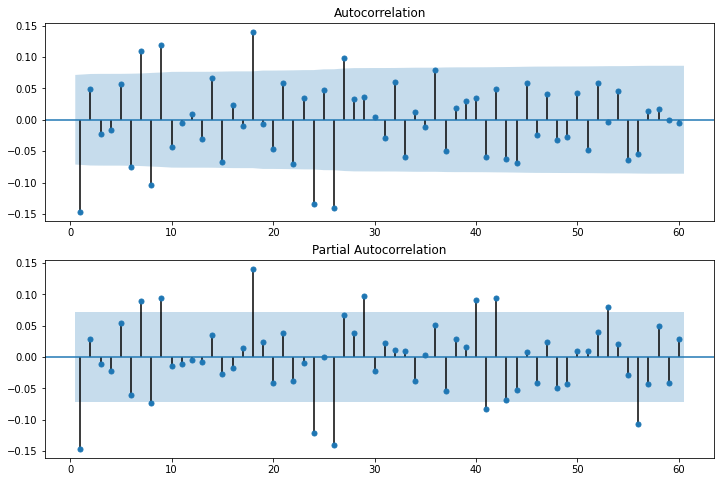

True

In [40]:
def indentification_2(series_stationary):
  from statsmodels.tsa.stattools import adfuller
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  # Identify what order of model will be the best fit.
  # Create figure
  fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
  
  # Plot the ACF of savings on ax1
  plot_acf(series_stationary, lags=60, zero=False, ax=ax1)

  # Plot the PACF of savings on ax2
  plot_pacf(series_stationary, lags=60, zero=False, ax=ax2)

  plt.show()
  adf_p_value = adfuller(series_stationary)[1]
  is_stationary = True if adf_p_value<0.05 else False
  assert is_stationary
  return True
indentification_2(time_series.diff().dropna())

In [41]:
def estimation(series_stationary, p_range=range(4), q_range=range(4)):
  from statsmodels.tsa.stattools import adfuller
  adf_p_value = adfuller(series_stationary)[1]
  is_stationary = True if adf_p_value<0.05 else False
  assert is_stationary

  from statsmodels.tsa.statespace.sarimax import SARIMAX
  order_aic_bic=[]
  # Loop over p values from 0-3
  for p in p_range:
    # Loop over q values from 0-3
      for q in q_range:
        try:
          # Create and fit ARMA(p,q) model
          model = SARIMAX(series_stationary, order=(p,0,q), trend='c')
          results = model.fit()
          
          # Print p, q, AIC, BIC
          print(p, q, results.aic, results.bic)
          order_aic_bic.append((p, q, results.aic, results.bic))
        except:
          print(p, q, None, None)

  # Choose the best results
  # Construct DataFrame from order_aic_bic
  order_df = pd.DataFrame(order_aic_bic, 
                          columns=['p', 'q', 'AIC', 'BIC'])

  # Print order_df in order of increasing AIC
  print(order_df.sort_values('AIC'))
  best_aic_order = (order_df.sort_values('AIC')['p'][0],
                    0,
                    order_df.sort_values('AIC')['q'][0],)
  
  # Print order_df in order of increasing BIC
  print(order_df.sort_values('BIC'))
  best_bic_order = (order_df.sort_values('BIC')['p'][0],
                    0,
                    order_df.sort_values('BIC')['q'][0],)
  if best_aic_order == best_bic_order:
    print(f'best_aic_order=best_bic_order = {best_aic_order}')
  else:
    print(f'best_aic_order: {best_aic_order}')
    print(f'best_aic_order: {best_bic_order}')

  return order_aic_bic, best_aic_order, best_bic_order
estimation(time_series.diff().dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


0 0 2886.539838221585 2895.793273720083
0 1 2873.347469289194 2887.227622536941
0 2 2873.9065393386554 2892.4134103356514


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


0 3 2875.3018087005626 2898.4353974468077
1 0 2872.233116569554 2886.113269817301


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


1 1 2873.5976473250385 2892.1045183220344


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


1 2 2875.573391714389 2898.706980460634


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  params_exog = []
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.k_ar > 0 and


1 3 2877.297811988777 2905.0581184842713
2 0 2873.611333173654 2892.11820417065


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 1 2875.580777568518 2898.714366314763


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 2 2877.596606834173 2905.3569133296673


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 3 2848.2088198039696 2880.595844048713
3 0 2875.5167164488175 2898.6503051950626


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


3 1 2877.471171774021 2905.2314782695153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


3 2 2875.0590139354827 2907.446038180226
3 3 2854.915709128427 2891.929451122419
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
15  3  3  2854.915709  2891.929451
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
14  3  2  2875.059014  2907.446038
3   0  3  2875.301809  2898.435397
12  3  0  2875.516716  2898.650305
6   1  2  2875.573392  2898.706980
9   2  1  2875.580778  2898.714366
7   1  3  2877.297812  2905.058118
13  3  1  2877.471172  2905.231478
10  2  2  2877.596607  2905.356913
0   0  0  2886.539838  2895.793274
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
15  3  3  2854.915709  2891.929451
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
0   0  0  2886.539838  2895.793274
3   0  3 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


([(0, 0, 2886.539838221585, 2895.793273720083),
  (0, 1, 2873.347469289194, 2887.227622536941),
  (0, 2, 2873.9065393386554, 2892.4134103356514),
  (0, 3, 2875.3018087005626, 2898.4353974468077),
  (1, 0, 2872.233116569554, 2886.113269817301),
  (1, 1, 2873.5976473250385, 2892.1045183220344),
  (1, 2, 2875.573391714389, 2898.706980460634),
  (1, 3, 2877.297811988777, 2905.0581184842713),
  (2, 0, 2873.611333173654, 2892.11820417065),
  (2, 1, 2875.580777568518, 2898.714366314763),
  (2, 2, 2877.596606834173, 2905.3569133296673),
  (2, 3, 2848.2088198039696, 2880.595844048713),
  (3, 0, 2875.5167164488175, 2898.6503051950626),
  (3, 1, 2877.471171774021, 2905.2314782695153),
  (3, 2, 2875.0590139354827, 2907.446038180226),
  (3, 3, 2854.915709128427, 2891.929451122419)],
 (0, 0, 0),
 (0, 0, 0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


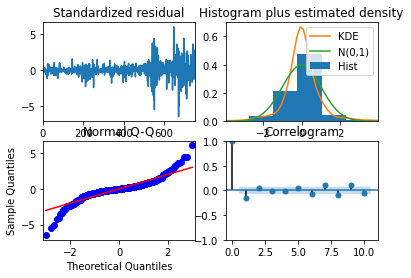

                           Statespace Model Results                           
Dep. Variable:                   AAPL   No. Observations:                  755
Model:                        SARIMAX   Log Likelihood               -1441.270
Date:                Sat, 15 May 2021   AIC                           2886.540
Time:                        17:39:15   BIC                           2895.793
Sample:                             0   HQIC                          2890.104
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1205      0.060      2.023      0.043       0.004       0.237
sigma2         2.6646      0.060     44.448      0.000       2.547       2.782
Ljung-Box (Q):                      143.93   Jarque-

In [42]:
def diagnostics(series_stationary, p, q):
  # Create and fit model
  model = SARIMAX(series_stationary, order=(p,0,q), trend='c')
  results = model.fit()

  # Create the 4 diagostics plots
  results.plot_diagnostics()
  plt.show()

  # Print summary
  print(results.summary())
diagnostics(time_series.diff().dropna(), 0,0)

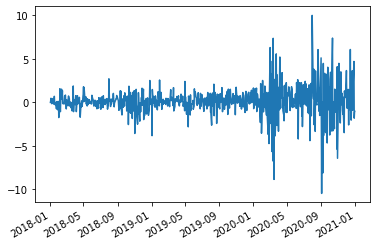

test statistic: -8.443930110470156
p-value: 1.7332051602480466e-13
Data is stationary.


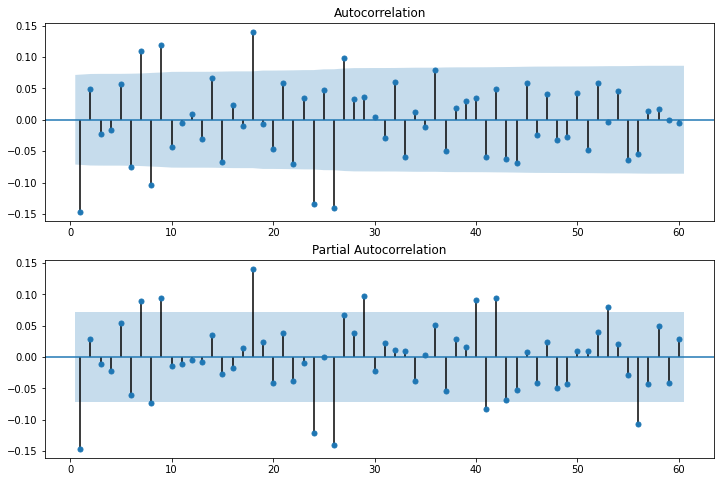

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


0 0 2886.539838221585 2895.793273720083
0 1 2873.347469289194 2887.227622536941
0 2 2873.9065393386554 2892.4134103356514


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


0 3 2875.3018087005626 2898.4353974468077
1 0 2872.233116569554 2886.113269817301


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


1 1 2873.5976473250385 2892.1045183220344


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


1 2 2875.573391714389 2898.706980460634


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  params_exog = []
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.k_ar > 0 and


1 3 2877.297811988777 2905.0581184842713
2 0 2873.611333173654 2892.11820417065


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 1 2875.580777568518 2898.714366314763


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 2 2877.596606834173 2905.3569133296673


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


2 3 2848.2088198039696 2880.595844048713
3 0 2875.5167164488175 2898.6503051950626


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


3 1 2877.471171774021 2905.2314782695153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


3 2 2875.0590139354827 2907.446038180226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


3 3 2854.915709128427 2891.929451122419
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
15  3  3  2854.915709  2891.929451
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
14  3  2  2875.059014  2907.446038
3   0  3  2875.301809  2898.435397
12  3  0  2875.516716  2898.650305
6   1  2  2875.573392  2898.706980
9   2  1  2875.580778  2898.714366
7   1  3  2877.297812  2905.058118
13  3  1  2877.471172  2905.231478
10  2  2  2877.596607  2905.356913
0   0  0  2886.539838  2895.793274
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
15  3  3  2854.915709  2891.929451
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
0   0  0  2886.539838  2895.793274
3   0  3  2875.301809  2898.435397
12  3  0  2875.

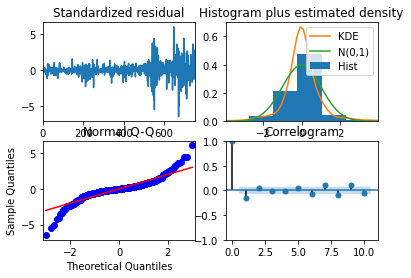

                           Statespace Model Results                           
Dep. Variable:                   AAPL   No. Observations:                  755
Model:                        SARIMAX   Log Likelihood               -1441.270
Date:                Sat, 15 May 2021   AIC                           2886.540
Time:                        17:39:25   BIC                           2895.793
Sample:                             0   HQIC                          2890.104
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1205      0.060      2.023      0.043       0.004       0.237
sigma2         2.6646      0.060     44.448      0.000       2.547       2.782
Ljung-Box (Q):                      143.93   Jarque-

In [43]:
def box_jenkins_method(series_with_unknown_charecteristics):
  if indentification(series_with_unknown_charecteristics):
    if indentification_2(series_with_unknown_charecteristics):
      (order_aic_bic,
      best_aic_order,
      best_bic_order) = estimation(series_with_unknown_charecteristics, p_range=range(4), q_range=range(4))
      
      diagnostics(series_with_unknown_charecteristics, 
                  p=best_aic_order[0],
                  q=best_aic_order[2])
box_jenkins_method(time_series.diff().dropna())

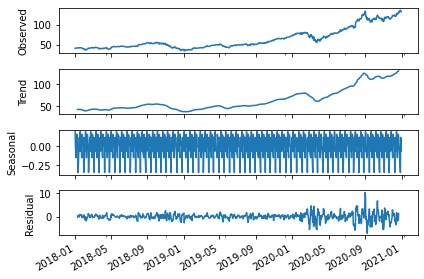

In [44]:
def plot_trend_seasonality_and_residuals(series,
                                         freq=12):
  # Import seasonal decompose
  from statsmodels.tsa.seasonal import seasonal_decompose

  # Perform additive decomposition
  decomp = seasonal_decompose(series, 
                              freq=freq)

  # Plot decomposition
  decomp.plot()
  plt.show()
plot_trend_seasonality_and_residuals(time_series)

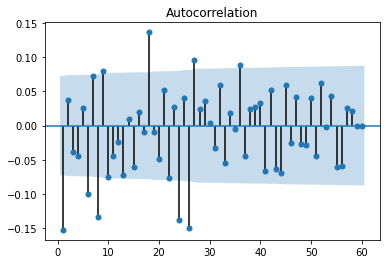

In [45]:
def plot_seasonal_acf_and_pacf(series):
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  # Subtract the rolling mean to detrend it
  series_2 = series - series.rolling(15).mean()

  # Drop the NaN values
  series_2 = series_2.dropna()

  # Create figure and subplots
  fig, ax1 = plt.subplots()

  # Plot the ACF
  plot_acf(series_2, lags=60, zero=False, ax=ax1)

  # Show figure
  plt.show()

  # Remember: Seasonaility period is the first significant peak 
plot_seasonal_acf_and_pacf(time_series.diff().dropna())

Performing stepwise search to minimize oob
 ARIMA(0,1,0)(0,0,0)[5] intercept   : OOB=9.948, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : OOB=9.209, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : OOB=9.480, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[5]             : OOB=11.874, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : OOB=9.254, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[5] intercept   : OOB=9.369, Time=0.90 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : OOB=9.274, Time=0.89 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : OOB=9.228, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[5] intercept   : OOB=9.767, Time=1.57 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : OOB=9.849, Time=0.32 sec
 ARIMA(2,1,0)(1,0,0)[5] intercept   : OOB=8.929, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : OOB=8.895, Time=0.29 sec
 ARIMA(2,1,0)(0,0,1)[5] intercept   : OOB=8.951, Time=0.51 sec
 ARIMA(2,1,0)(1,0,1)[5] intercept   : OOB=8.995, Time=1.00 sec
 ARIMA(3,1,0)(0,0,0)[5] intercept   : OOB=9.254, Time=0.39 sec
 ARIMA(2,1,

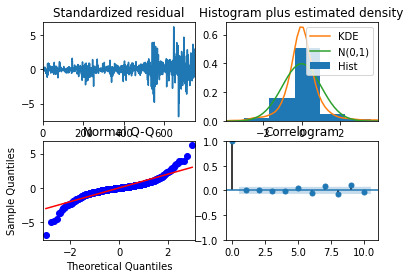

In [66]:
def auto_arima(y=time_series,
                        seasonal=True,
                        m=7,
                        start_p=0, 
                        start_d=0,
                        start_q=0,
                        max_p=3, 
                        max_d=3,
                        max_q=3,
                        start_P=0, 
                        start_D=0,
                        start_Q=0,
                        max_P=3,
                        max_D=3, 
                        max_Q=3,
                        information_criterion='aic',
                        out_of_sample_size = 0,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True):
  import pmdarima as pm

  # Create model for SARIMAX(p,1,q)(P,1,Q)7
  pm_model = pm.auto_arima(y=time_series ,
                        seasonal=seasonal, 
                        m=m,
                        start_p=start_p,
                        start_d=start_d,
                        start_q=start_q,
                        max_p=max_p,
                        max_d=max_d,
                        max_q=max_q,
                        start_P=start_P,
                        start_D=start_D,
                        start_Q=start_Q,
                        max_P=max_P,
                        max_D=max_D,
                        max_Q=max_Q,
                        information_criterion=information_criterion,
                        out_of_sample_size = out_of_sample_size,
                        trace=trace,
                        error_action=error_action,
                        suppress_warnings=suppress_warnings) 

  # Print model summary
  print(pm_model.summary())

  # Plot common diagnostics
  pm_model.plot_diagnostics()
  plt.show()

  return model
  
model = auto_arima(y=time_series, m=5, information_criterion='oob', out_of_sample_size=5)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=2886.540, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=2872.712, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=2873.840, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=2888.641, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[21] intercept   : AIC=2872.233, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[21] intercept   : AIC=2872.802, Time=0.91 sec
 ARIMA(1,1,0)(1,0,1)[21] intercept   : AIC=2873.024, Time=5.35 sec
 ARIMA(2,1,0)(0,0,0)[21] intercept   : AIC=2873.611, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[21] intercept   : AIC=2873.598, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[21] intercept   : AIC=2873.347, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[21] intercept   : AIC=2875.581, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[21]             : AIC=2875.721, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[21] intercept
Total fit time: 9.291 seconds
                           Statespace Model Results                        

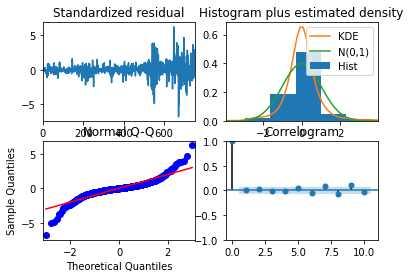

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(3, 1, 0, 5),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [55]:
auto_arima(y=time_series, m=21)